# Physics Informed Neural Networks

This notebook provides a set of utilities allowing to compute the power flow under the physics informed graph neural network

In [21]:
import matplotlib.pyplot as plt
import torch
from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from utils.graph_utils import prepare_dataset

In [85]:
import importlib
import utils.graph_utils
importlib.reload(utils.graph_utils)

<module 'utils.graph_utils' from '/home/milad.leyli-abadi/Github/ml4physim_startingkit_powergrid/utils/graph_utils.py'>

In [2]:
# Use some required pathes
import pathlib
DATA_PATH = pathlib.Path().resolve() / "input_data_local" / "lips_case14_sandbox"
BENCH_CONFIG_PATH = pathlib.Path().resolve() / "configs" / "benchmarks" / "lips_case14_sandbox.ini"

In [3]:
benchmark = PowerGridBenchmark(benchmark_name="Benchmark_DC",
                               benchmark_path=DATA_PATH,
                               load_data_set=True,
                               log_path=None,
                               config_path=BENCH_CONFIG_PATH,
                              )

In [4]:
print(benchmark.train_dataset.size)

100000


In [ ]:
device = torch.device("cuda:0")
train_loader, val_loader, test_loader, test_ood_loader = prepare_dataset(benchmark=benchmark, batch_size=512, device=device)

In [16]:
batch = next(iter(test_loader))

In [17]:
batch

DataBatch(x=[7168, 2], edge_index=[2, 26624], edge_attr=[26624], y=[7168, 1], edge_index_no_diag=[2, 19456], edge_attr_no_diag=[19456], ybus=[7168, 14], batch=[7168], ptr=[513])

In [18]:
from utils.graph_utils import GPGmodel_without_NN

gpg_model_wo_nn = GPGmodel_without_NN(num_gnn_layers=100, device=device)
gpg_model_wo_nn.to(device)

GPGmodel_without_NN(
  (input_layer): GPGinput_without_NN()
  (lc_layer): LocalConservationLayer()
  (inter_layers): ModuleList(
    (0-99): 100 x GPGintermediate()
  )
)

In [63]:
predictions = []
observations = []
for batch in test_loader:
    out, errors = gpg_model_wo_nn(batch)
    predictions.append(out)
    observations.append(batch.y)
observations = torch.vstack(observations)
predictions = torch.vstack(predictions)
err = [float(error.detach().cpu().numpy()) for error in errors]

Text(0, 0.5, 'Local Conservation Error')

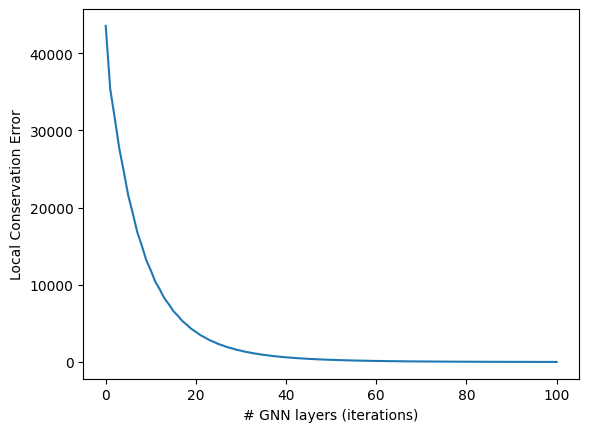

In [64]:
plt.figure()
plt.plot(err)
plt.xlabel("# GNN layers (iterations)")
plt.ylabel("Local Conservation Error")

In [66]:
import math
predictions = predictions * (180/math.pi)

In [67]:
MAPE = abs((observations - (predictions)) / (observations + 1e-10)).mean()
print("MAPE: ", MAPE)

MAPE:  tensor(0.0001, device='cuda:0', dtype=torch.float64)


In [69]:
from lips.metrics.ml_metrics.external_metrics import mape_quantile

MAPE_10 = mape_quantile(y_true=observations.detach().cpu(), y_pred=predictions.detach().cpu(), quantile=0.9)
print("MAPE 10: ", MAPE_10)

MAPE 10:  0.00014607468753798024


In [86]:
import warnings
from utils.graph_utils import get_obs, get_all_active_powers
warnings.filterwarnings("ignore")
env, obs = get_obs(benchmark)
p_ors_pred, p_exs_pred = get_all_active_powers(benchmark._test_dataset.data,
                                               obs,
                                               theta_bus=predictions.view(-1,14).cpu())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [87]:
my_predictions = {}
my_predictions["p_or"] = p_ors_pred
my_predictions["p_ex"] = p_exs_pred

In [88]:
MAPE10_Power = mape_quantile(y_true=benchmark._test_dataset.data["p_or"], 
                             y_pred=my_predictions["p_or"], 
                             quantile=0.9)
print("MAPE10 on Active Powers: ", MAPE10_Power)

MAPE10 on Active Powers:  0.00023004051043067157


In [89]:
from sklearn.metrics import mean_absolute_percentage_error
print("MAPE: ", mean_absolute_percentage_error(my_predictions["p_or"], benchmark._test_dataset.data["p_or"]))

MAPE:  0.033640757


In [92]:
from lips.metrics.power_grid.local_conservation import local_conservation

LC_tolerance = 1e-2

verification = local_conservation(predictions=my_predictions,
                                  observations=benchmark._test_dataset.data,
                                  tolerance=LC_tolerance,
                                  env=env,
                                  result_level=2)
print(verification["violation_percentage"])

5.282857142857143
